['Ace' 'Akainu' 'Brook' 'Chopper' 'Luffy' 'Mihawk' 'Nami' 'Rayleigh'
 'Robin' 'Sanji' 'Usopp' 'Zoro']
12
Image shape:  (224, 224, 3)
Label:  2


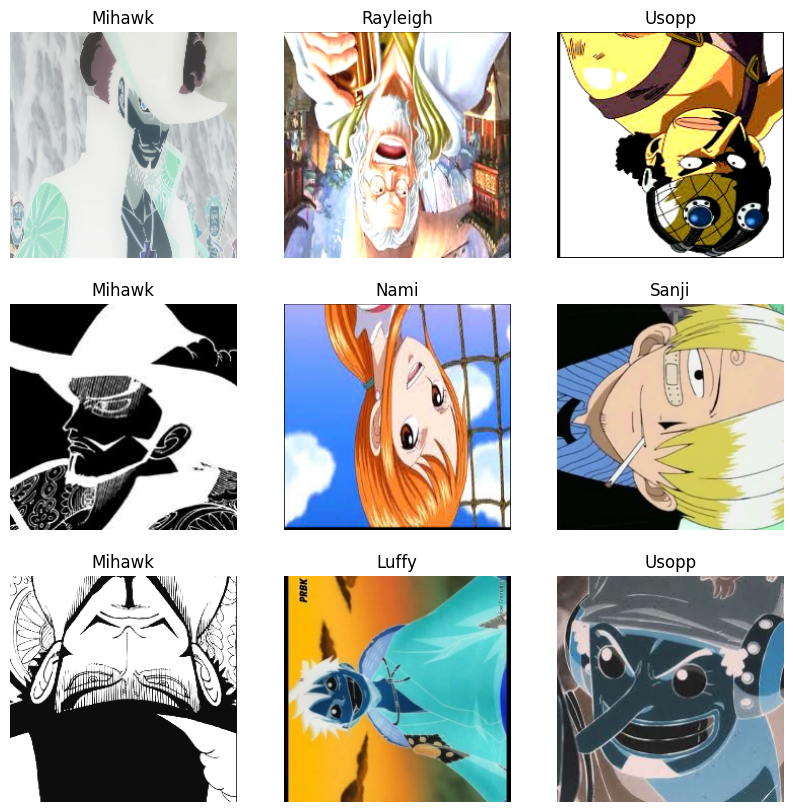

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
#데이터 로드
data_dir = pathlib.Path("C:\\Users\\User\\Desktop\\Data\\Data")

image_count = len(list(data_dir.glob('*/*')))

#데이터셋 생성 후 랜덤으로 셔플
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)


# 클래스 명 생성(분류할 사진의 캐릭터 이름)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
print(len(class_names))
#훈련 및 검증 데이터셋 분할 생성
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

#autotune 사용 - 입력 파이프라인의 성능을 최적화하는 기능. 
# 병렬 처리 설정을 자동으로 조정하여 처리량 최적화하고 대기시간을 줄임.
batch_size = 64
img_height = 224
img_width = 224
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
AUTOTUNE = tf.data.AUTOTUNE

# 원 핫 인코딩 생성, 및 정수 레이블로 변환
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)
# 원하는 높이와 너비로 크기가 조정된 이미지의 3D텐서 반환
# 원하는 크기로 조정
def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])
#위 함수 두개 사용하여 라벨 및 이미지 텐서 생성
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label
# taain val 데이터셋 생성 오토튠 사용
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
# 성능 향상 위해 다양한 변환 적용. 캐싱, 셔플링, 일괄처리, 프리패칭
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
image_batch, label_batch = next(iter(train_ds))
# 이미지 9개 시각화.
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [2]:
model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])


In [3]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=early_stop 
  )

Epoch 1/20


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


98/98 [==============================] - 725s 7s/step - loss: 7.2932 - accuracy: 0.0011 - val_loss: 7.1801 - val_accuracy: 0.0038
Epoch 2/20
98/98 [==============================] - 683s 7s/step - loss: 6.5489 - accuracy: 0.0101 - val_loss: 5.9176 - val_accuracy: 0.0358
Epoch 3/20
98/98 [==============================] - 682s 7s/step - loss: 5.7071 - accuracy: 0.0590 - val_loss: 4.7269 - val_accuracy: 0.1622
Epoch 4/20
98/98 [==============================] - 683s 7s/step - loss: 4.7633 - accuracy: 0.1847 - val_loss: 3.6191 - val_accuracy: 0.3531
Epoch 5/20
98/98 [==============================] - 683s 7s/step - loss: 3.8257 - accuracy: 0.3623 - val_loss: 2.7659 - val_accuracy: 0.5038
Epoch 6/20
98/98 [==============================] - 679s 7s/step - loss: 3.0068 - accuracy: 0.4955 - val_loss: 2.1753 - val_accuracy: 0.6047
Epoch 7/20
98/98 [==============================] - 683s 7s/step - loss: 2.3147 - accuracy: 0.6088 - val_loss: 1.7161 - val_accuracy: 0.6852
Epoch 8/20
98/98 [======

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

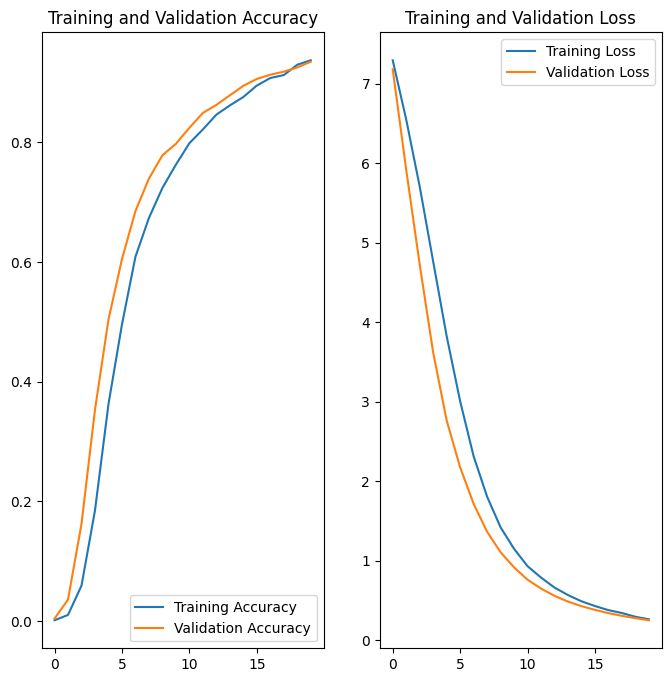

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [73]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [34]:
luffy_url = "C:\\Users\\User\\Desktop\\Data\\Data\\Rayleigh\\25.png"
luffy_path = tf.keras.utils.get_file(origin=luffy_url)
img = tf.keras.utils.load_img(
    luffy_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])

Exception: URL fetch failure on C:\Users\User\Desktop\Data\Data\Rayleigh\25.png: None -- unknown url type: c

In [10]:
from PIL import Image

1/1 [==============================] - 0s 79ms/step
Ace


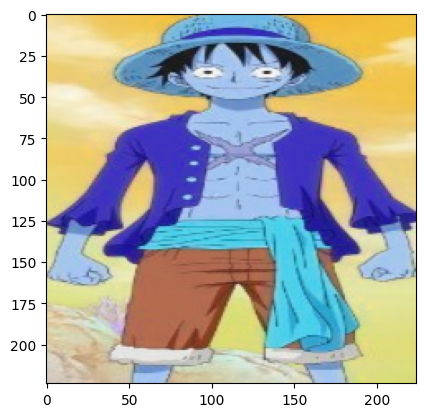

In [75]:
img = cv2.imread("C:\\Users\\User\\Desktop\\Data\\Data\\Luffy\\1.jpg")
img = cv2.resize(img, (224, 224))
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])
plt.imshow(img)


1/1 [==============================] - 0s 48ms/step
Rayleigh


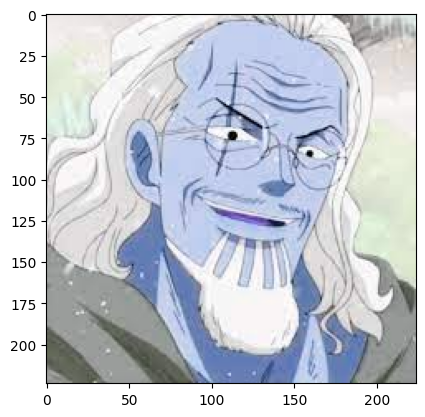

In [47]:
img = cv2.imread("C:\\Users\\User\\Desktop\\Data\\Data\\Rayleigh\\92.png")
img = cv2.resize(img, (224, 224))
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])
plt.imshow(img)

1/1 [==============================] - 0s 49ms/step
Akainu


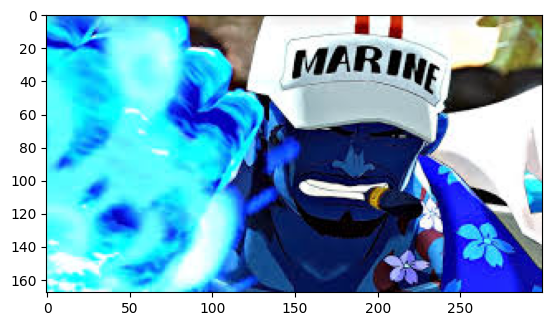

In [72]:
img = cv2.imread("C:\\Users\\User\\Desktop\\Data\\Data\\Akainu\\65.png")

img = cv2.resize(img, (224, 224))
plt.imshow(img)
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])


1/1 [==============================] - 0s 55ms/step
Robin


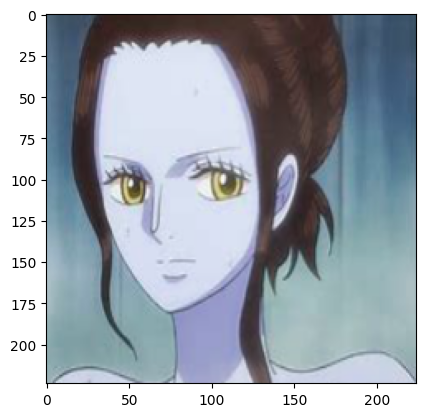

In [62]:
import cv2
img = cv2.imread("C:\\Users\\User\\Desktop\\Data\\Data\\Robin\\103.png")
img = cv2.resize(img, (224, 224))
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])
plt.imshow(img)

1/1 [==============================] - 0s 48ms/step
Zoro


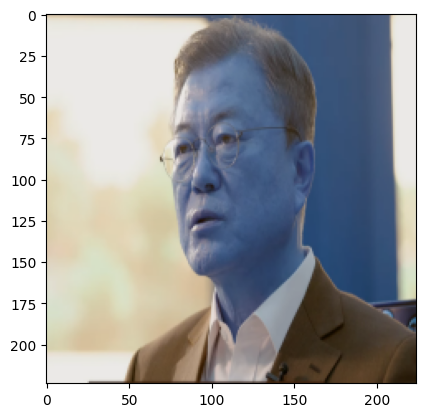

In [60]:
import cv2
img = cv2.imread("C:\\Users\\User\\Desktop\\DLP\\moon3.png")
img = cv2.resize(img, (224, 224))
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])
plt.imshow(img)

1/1 [==============================] - 0s 51ms/step
Zoro


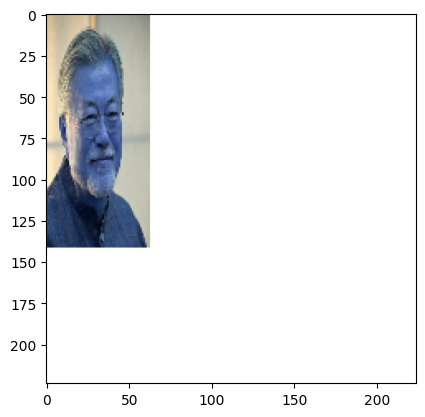

In [63]:
import cv2
img = cv2.imread("C:\\Users\\User\\Desktop\\DLP\\moon2.png")
img = cv2.resize(img, (224, 224))
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])
plt.imshow(img)

1/1 [==============================] - 0s 56ms/step
Zoro


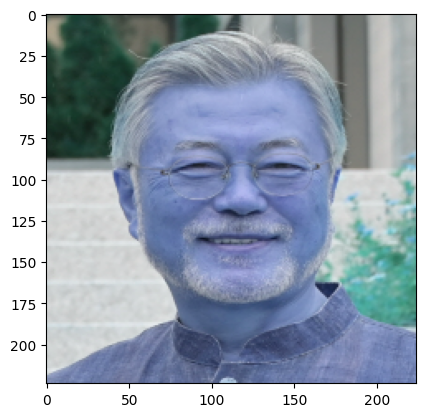

In [64]:
import cv2
img = cv2.imread("C:\\Users\\User\\Desktop\\DLP\\moon.png")
img = cv2.resize(img, (224, 224))
img = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(class_names[np.argmax(score)])
plt.imshow(img)